# 3. Background Removal with Robust PCA

**Our goal today**: ![background removal](images/surveillance3.png)

## Getting Started

Let's use the real video 003 dataset from [BMC 2012 Background Models Challenge Dataset](http://bmc.iut-auvergne.com/?page_id=24)

Other sources of datasets:
- [Human Activity Video Datasets](https://www.cs.utexas.edu/~chaoyeh/web_action_data/dataset_list.html)
- [Background Subtraction Website](https://sites.google.com/site/backgroundsubtraction/test-sequences) (a few links on this site are broken/outdated, but many work)

Import needed libraries:

In [2]:
import moviepy.editor as mpe
# from IPython.display import display
from glob import glob

In [3]:
import sys, os
import numpy as np
import scipy

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# MAX_ITERS = 10
TOL = 1.0e-8

### Helper Methods

In [6]:
def create_data_matrix_from_video(clip, k=5, scale=50):
    return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i/float(k))).astype(int), 
                      scale).flatten() for i in range(k * int(clip.duration))]).T

In [7]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [8]:
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

### Load and view the data

In [9]:
video = mpe.VideoFileClip("data/Video_003.avi")

In [10]:
video.duration

113.57

An image from 1 moment in time is 60 pixels by 80 pixels (when scaled). We can *unroll* that picture into a single long row. So instead of having a 2D picture that is $60 \times 80$, we have a $1 \times 4,800$ row 

This isn't very human-readable, but it's handy because it lets us stack the images from different times on top of one another, to put a video all into 1 matrix.  If we took the video image every tenth of a second for 113 seconds (so 11,300 different images, each from a different point in time), we'd have a $4800 \times 11300$ matrix, representing the video! 

In [11]:
scale = 100   # Adjust scale to change resolution of image
dims = (int(240 * (scale/100)), int(320 * (scale/100)))

In [12]:
# M = create_data_matrix_from_video(video, 100, scale)
M = np.load("high_res_surveillance_matrix.npy")

In [13]:
print(dims, M.shape)

(240, 320) (76800, 11300)


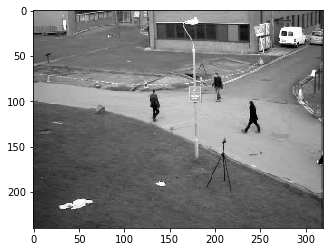

In [79]:
plt.imshow(np.reshape(M[:,140], dims), cmap='gray');

Since `create_data_from_matrix` is somewhat slow, we will save our matrix.  In general, whenever you have slow pre-processing steps, it's a good idea to save the results for future use.

In [80]:
np.save("high_res_surveillance_matrix.npy", M)

Note: High-res M is too big to plot, so only run the below with the low-res version

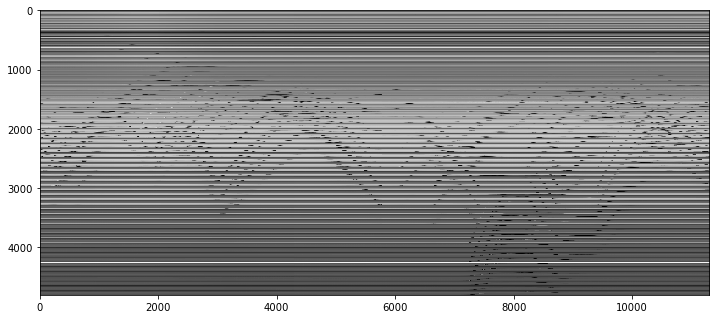

In [33]:
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')

**Questions**: What are those wavy black lines?  What are the horizontal lines?

In [ ]:
plt.imsave(fname="image1.jpg", arr=np.reshape(M[:,140], dims), cmap='gray')

## SVD

**Review from Lesson 2**:
- What kind of matrices are returned by SVD?
- What is a way to speed up truncated SVD?

### A first attempt with SVD

In [14]:
from sklearn import decomposition

In [15]:
u, s, v = decomposition.randomized_svd(M, 2)

In [16]:
low_rank = u @ np.diag(s) @ v

In [17]:
low_rank.shape

(76800, 11300)

The below images were created with high-res data.  Very slow to process:

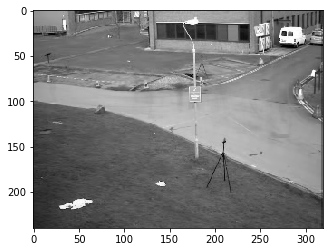

In [18]:
plt.imshow(np.reshape(low_rank[:,140], dims), cmap='gray');

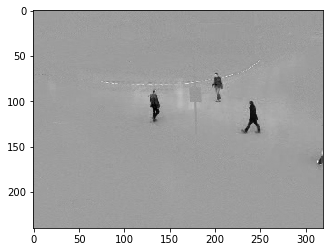

In [35]:
plt.imshow(np.reshape(M[:,140] - low_rank[:,140], dims), cmap='gray');

Let's zoom in on the people:

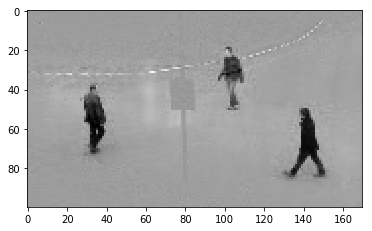

In [36]:
plt.imshow(np.reshape(M[:,140] - low_rank[:,140], dims)[50:150,100:270], cmap='gray');

This is amazing for such a simple approach!  We get somewhat better results through a more complicated algorithm below.

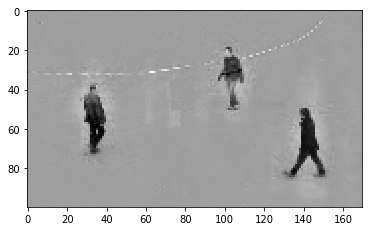

In [33]:
plt.imshow(np.reshape(S[:,140], dims)[50:150,100:270], cmap='gray')

## Principal Component Analysis (PCA)

When dealing with high-dimensional data sets, we often leverage on the fact that the data has **low intrinsic dimensionality** in order to alleviate the curse of dimensionality and scale (perhaps it lies in a low-dimensional subspace or lies on a low-dimensional manifold). [Principal component analysis](http://setosa.io/ev/principal-component-analysis/) is handy for eliminating dimensions.  Classical PCA seeks the best rank-$k$ estimate $L$ of $M$ (minimizing $\| M - L \|$ where $L$ has rank-$k$)

Traditional PCA can handle small noise, but is brittle with respect to grossly corrupted observations-- even one grossly corrupt observation can significantly mess up answer.

**Robust PCA** factors a matrix into the sum of two matrices, $M = L + S$, where $M$ is the original matrix, $L$ is **low-rank**, and $S$ is **sparse**.  This is what we'll be using for the background removal problem! **Low-rank** means that the matrix has a lot of duplicate information-- in this case, it's the background, which is the same in every scene (talk about duplicate info!).  **Sparse** means that the matrix has mostly zero entries-- in this case, see how the picture of the foreground (the people) is mostly empty.  (In the case of corrupted data, $S$ is capturing the corrupted entries).

### Applications of Robust PCA
- **Video Surveillance**

- **Face Recognition** photos from this excellent [tutorial](https://jeankossaifi.github.io/tensorly/rpca.html).  The dataset here consists of images of the faces of several people taken from the same angle but with different illumniations.

  <img src="images/faces_rpca.png" alt="Robust PCA" style="width: 80%"/>
  ([Source: Jean Kossaifi](https://jeankossaifi.github.io/tensorly/rpca.html))

  <img src="images/faces_rpca_gross.png" alt="Robust PCA" style="width: 80%"/>
  ([Source: Jean Kossaifi](https://jeankossaifi.github.io/tensorly/rpca.html))

- Latent Semantic Indexing: $L$ captures common words used in all documents while $S$ captures the few key words that best distinguish each document from others

- Ranking and Collaborative Filtering: a small portion of the available rankings could be noisy and even tampered with (see [Netflix RAD - Outlier Detection on Big Data](http://techblog.netflix.com/2015/02/rad-outlier-detection-on-big-data.html) on the official netflix blog)

### L1 norm induces sparsity

The unit ball $\lVert x \rVert_1 = 1$ is a diamond in the L1 norm.  It's extrema are the corners:

 <img src="images/L1vsL2.jpg" alt="L1 norm" style="width: 60%"/>
  ([Source](https://www.quora.com/Why-is-L1-regularization-supposed-to-lead-to-sparsity-than-L2))
  
  A similar perspective is to look at the *contours* of the loss function:
 <img src="images/L1vsL2_2.png" alt="L2 norm" style="width: 60%"/>
  ([Source](https://www.quora.com/Why-is-L1-regularization-better-than-L2-regularization-provided-that-all-Norms-are-equivalent))

### Optimization Problem

Robust PCA can be written:

$$ minimize\; \lVert L \rVert_* + \lambda\lVert S \rVert_1 \\ subject\;to\; L + S = M$$
 
where:

- $\lVert \cdot \rVert_1$ is the **L1 norm**.  Minimizing the [L1 norm](https://medium.com/@shiyan/l1-norm-regularization-and-sparsity-explained-for-dummies-5b0e4be3938a) results in sparse values.  For a matrix, the L1 norm is equal to the [maximum absolute column norm](https://math.stackexchange.com/questions/519279/why-is-the-matrix-norm-a-1-maximum-absolute-column-sum-of-the-matrix).

- $ \lVert \cdot \rVert_* $ is the **nuclear norm**, which is the L1 norm of the singular values.  Trying to minimize this results in sparse singular values --> low rank.


### Implementing an algorithm from a paper

#### Source
We will use the general **primary component pursuit algorithm** from this [Robust PCA paper](https://arxiv.org/pdf/0912.3599.pdf) (Candes, Li, Ma, Wright), in the specific form of **Matrix Completion via the Inexact ALM Method** found in [section 3.1 of this paper](https://arxiv.org/pdf/1009.5055.pdf) (Lin, Chen, Ma).  I also referenced the implemenations found [here](https://github.com/shriphani/robust_pcp/blob/master/robust_pcp.py) and [here](https://github.com/dfm/pcp/blob/master/pcp.py).

#### The Good Parts

Section 1 of Candes, Li, Ma, Wright is nicely written, and section 5 Algorithms is our key interest.  **You don't need to know the math or understand the proofs to implement an algorithm from a paper.**  You will need to try different things and comb through resources for useful tidbits.  This field has more theoretical researchers and less pragmatic advice.  It took months to find what I needed and get this working.

The algorithm shows up on page 29:

 <img src="images/pcp_algorithm.png" alt="PCP algorithm" style="width: 100%"/>

needed definitions of $\mathcal{S}$, the Shrinkage operator, and $\mathcal{D}$, the singular value thresholding operator:

 <img src="images/candes.png" alt="PCP algorithm" style="width: 100%"/>

Section 3.1 of [Chen, Lin, Ma]() contains a faster vartiation of this:

 <img src="images/rpca_inexact.png" alt="Inexact RPCA" style="width: 80%"/>

And Section 4 has some very helpful implementation details on how many singular values to calculate (as well as how to choose the parameter values):

 <img src="images/svp_value.png" alt="SVP values" style="width:70%"/> 

### If you want to learn more of the theory:

- Convex Optimization by Stephen Boyd (Stanford Prof): 
  - [OpenEdX Videos](https://www.youtube.com/playlist?list=PLbBM_dvjud8oFj09MqqYnGSrT6zek42Q0)
  - [Jupyter Notebooks](http://web.stanford.edu/~boyd/papers/cvx_short_course.html)
- Alternating Direction Method of Multipliers (more [Stephen Boyd](http://stanford.edu/~boyd/admm.html))

## Robust PCA (via Primary Component Pursuit)

### Methods

We will use [Facebook's Fast Randomized PCA](https://github.com/facebook/fbpca) library.

In [20]:
from scipy import sparse
from sklearn.utils.extmath import randomized_svd
import fbpca

In [21]:
TOL=1e-9
MAX_ITERS=3

In [22]:
def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL

In [23]:
def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

In [24]:
def _svd(M, rank): return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)

In [25]:
def norm_op(M): return _svd(M, 1)[1][0]

In [26]:
def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz

In [169]:
def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape
        
    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    for i in range(maxiter):
        X2 = X + Y/mu
        S = shrink(X2 - L, lamda/mu)
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        sv = svp + (1 if svp < sv else round(0.05*n))
        Z = X - L - S
        Y += mu*Z; mu *= rho
        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break
    if trans: L=L.T; S=S.T
    return L, S

Questions: where is rank talked about, coefficients?

the algorithm again (page 29 of [Candes, Li, Ma, and Wright](https://arxiv.org/pdf/0912.3599.pdf))

 <img src="images/pcp_algorithm.png" alt="PCP algorithm" style="width: 100%"/>

### Results

In [28]:
L, S =  pcp(M, maxiter=5, k=10)

error:  0.148988890837
error:  0.0606744606669
error:  0.00901552753877
error:  0.000694917910056
error:  1.61176008193e-05


In [37]:
np.save("high_res_L.npy", L)
np.save("high_res_S.npy", S)

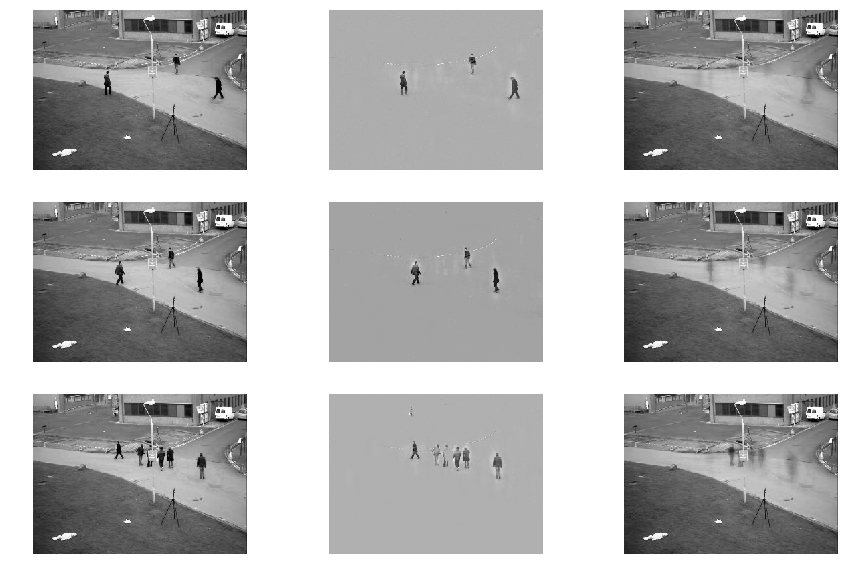

In [38]:
f = plt_images(M, S, L, [0, 100, 1000], dims)

Extracting a bit of the foreground is easier than identifying the background.  To accurately get the background, you need to remove all the foreground, not just parts of it

## LU Factorization

Both `fbpca` and our own `randomized_range_finder` methods used LU factorization, which factors a matrix into the product of a lower triangular matrix and an upper triangular matrix.

#### Gaussian Elimination

This section is based on lectures 20-22 in Trefethen.

Let's use Gaussian Elimination by hand to review:

A =
 \begin{pmatrix}
  1 & -2 & -2 & -3 \\
  3 & -9 & 0 & -9 \\
  -1 & 2 & 4 & 7  \\
  -3 & -6 & 26 & 2
 \end{pmatrix}

#### Answer:

$$ LU = \begin{bmatrix} 1 & 0 & 0 & 0\\ 3 & 1 & 0 & 0 \\ -1 & 0 & 1 & 0 \\ -3 & 4 & -2 & 1\end{bmatrix} \cdot \begin{bmatrix} 1 & -2 & -2 & -3 \\ 0 & -3 & 6 & 0 \\ 0 & 0 & 2 & 4 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

Above example is from Lectures 20, 21 of Trefethen.

**Gaussian Elimination** transform a linear system into an upper triangular one by applying linear transformations on the left.  It is *triangular triangularization*.

$ L_{m-1} \dots L_2 L_1 A = U $

L is *unit lower-triangular*: all diagonal entries are 1

In [76]:
def LU(A):
    U = np.copy(A)
    m, n = A.shape
    L = np.eye(n)
    for k in range(n-1):
        for j in range(k+1,n):
            L[j,k] = U[j,k]/U[k,k]
            U[j,k:n] -= L[j,k] * U[k,k:n]
    return L, U

In [74]:
A = np.array([[2,1,1,0],[4,3,3,1],[8,7,9,5],[6,7,9,8]]).astype(np.float)

In [43]:
L, U = LU(A)

In [44]:
np.allclose(A, L @ U)

True

The LU factorization is useful!

Solving Ax = b becomes LUx = b:
1. find A = LU
2. solve Ly = b
3. solve Ux = y

**Work**

Work for Gaussian Elimination: $2\cdot\frac{1}{3} n^3$

**Memory**

Above, we created two new matrices, $L$ and $U$.  However, we can store the values of $L$ and $U$ in our matrix A (overwriting the original matrix).  Since the diagonal of $L$ is all $1$s, it doesn't need to be stored.  Doing factorizations or computations **in-place** is a common technique in numerical linear algebra to save memory.  Note: you wouldn't want to do this if you needed to use your original matrix $A$ again in the future.  One of the homework questions is to rewrite the LU method to operate in place.

Consider the matrix $$ A = \begin{bmatrix} 10^{-20} & 1 \\ 1 & 1 \end{bmatrix} $$

In [79]:
A = np.array([[1e-20, 1], [1,1]])

By hand, use Gaussian Elimination to calculate what L and U are:

#### Answer

In [170]:
#Exercise:


SyntaxError: invalid syntax (<ipython-input-170-f963179aee0c>, line 2)

In [44]:
np.set_printoptions(suppress=True)

In [49]:
#Exercise:


array([[ 0.,  1.],
       [ 1.,  0.]])

In [81]:
L2, U2 = LU(A)

In [82]:
L2, U2

(array([[  1.00000000e+00,   0.00000000e+00],
        [  1.00000000e+20,   1.00000000e+00]]),
 array([[  1.00000000e-20,   1.00000000e+00],
        [  0.00000000e+00,  -1.00000000e+20]]))

In [84]:
np.allclose(L1, L2)

True

In [85]:
np.allclose(U1, U2)

True

In [86]:
np.allclose(A, L2 @ U2)

False

This is the motivation for $LU$ factorization **with pivoting**.

This also illustrates that LU factorization is *stable*, but not *backward stable*. (spoiler alert: even with partial pivoting, LU is "explosively unstable" for certain matrices, yet stable in practice)

#### Stability

An algorithm $\hat{f}$ for a problem $f$ is **stable** if for each $x$,
$$ \frac{\lVert \hat{f}(x) - f(y) \rVert}{ \lVert f(y) \rVert } = \mathcal{O}(\varepsilon_{machine}) $$

for some $y$ with
$$ \frac{\lVert y - x \rVert }{\lVert x \rVert} = \mathcal{O}(\varepsilon_{machine}) $$

**A stable algorithm gives nearly the right answer to nearly the right question** (Trefethen, pg 104)

To translate that:
- right question: $x$
- nearly the right question: $y$
- right answer: $f$
- right answer to nearly the right question: $f(y)$

#### Backwards Stability

Backwards stability is both **stronger** and **simpler** than stability. 

An algorithm $\hat{f}$ for a problem $f$ is **backwards stable** if for each $x$,
$$ \hat{f}(x) = f(y) $$

for some $y$ with
$$ \frac{\lVert y - x \rVert }{\lVert x \rVert} = \mathcal{O}(\varepsilon_{machine}) $$

**A backwards stable algorithm gives exactly the right answer to nearly the right question** (Trefethen, pg 104)

Translation:

- right question: $x$
- nearly the right question: $y$
- right answer: $f$
- right answer to nearly the right question: $f(y)$

### LU factorization with Partial Pivoting

Let's now look at the matrix $$ \hat{A} = \begin{bmatrix} 1 & 1 \\ 10^{-20} & 1 \end{bmatrix} $$

In [89]:
A = np.array([[1,1], [1e-20, 1]])

By hand, use Gaussian Elimination to calculate what L and U are:

#### Answer

In [ ]:
#Exercise:


In [90]:
L, U = LU(A)

In [93]:
np.allclose(A, L @ U)

True

Idea: We can switch the order of the rows around to get more stable answers! This is equivalent to multiplying by a permutation matrix $P$.  For instance,

$$\begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \cdot \begin{bmatrix} 10^{-20} & 1 \\ 1 & 1 \end{bmatrix} =  \begin{bmatrix} 1 & 1 \\ 10^{-20} & 1 \end{bmatrix} $$

$$ PA = \hat{A} $$

Apply Gaussian elimination to $PA$.

At each step, choose the largest value in column k, and move that row to be row k.

#### Homework

In [100]:
def swap(a,b):
    temp = np.copy(a)
    a[:] = b
    b[:] = temp

a=np.array([1,2,3])
b=np.array([3,2,1])
swap(a,b)
a,b

In [102]:
#Exercise: re-write the LU factorization above to use pivoting


#### Example

In [104]:
A = np.array([[2,1,1,0],[4,3,3,1],[8,7,9,5],[6,7,9,8]]).astype(np.float)

In [105]:
L, U, P = LU_pivot(A)

Can compare below to answers in Trefethen, page 159:

In [106]:
A

array([[ 2.,  1.,  1.,  0.],
       [ 4.,  3.,  3.,  1.],
       [ 8.,  7.,  9.,  5.],
       [ 6.,  7.,  9.,  8.]])

In [107]:
U

array([[ 8.        ,  7.        ,  9.        ,  5.        ],
       [ 0.        ,  1.75      ,  2.25      ,  4.25      ],
       [ 0.        ,  0.        , -0.28571429,  0.57142857],
       [ 0.        ,  0.        ,  0.        , -2.        ]])

In [114]:
P

array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.]])

**Partial pivoting** permutes the rows. It is such a universal practice, that this is usually what is meant by *LU factorization*.

**Complete pivoting** permutes the rows and columns.  Complete pivoting is significantly time-consuming and rarely used in practice.

#### Example

Consider the system of equations:

$$ \begin{bmatrix} 1 & 0 & 0  & 0 & 0 & 1 \\ -1 & 1 & 0  & 0 & 0 & 1 \\ -1 & -1 & 1  & 0 & 0 & 1 \\ -1 & -1 & -1  & 1 & 0 & 1  \\  -1 & -1 & -1  & -1 & 1 & 1 \\ -1 & -1 & -1  & -1 & -1 & 1 \end{bmatrix} \mathbf{x} = \begin{bmatrix} 1 \\ 1 \\ 1  \\ 1 \\ 2 \\ 1 \end{bmatrix} $$

In [142]:
def make_matrix(n):
    A = np.eye(n)
    for i in range(n):
        A[i,-1] = 1
        for j in range(i):
            A[i,j] = -1
    return A 

In [139]:
def make_vector(n):
    b = np.ones(n)
    b[-2] = 2
    return b

In [140]:
make_vector(7)

array([ 1.,  1.,  1.,  1.,  1.,  2.,  1.])

#### Exercise

Recall from above that we can use the LU factorization to solve a system of equations.  Scipy has this funtionality.  Calculate the output below for $n=10,\,20,\,30,\,40,\,50,\,60$.  Turn to your neighbor and explain what is happening.

In [168]:
n = 10
scipy.linalg.lu_solve(scipy.linalg.lu_factor(make_matrix(n)), make_vector(n))

array([-0.00195312, -0.00390625, -0.0078125 , -0.015625  , -0.03125   ,
       -0.0625    , -0.125     , -0.25      ,  0.5       ,  1.00195312])

Exercise: Let's use Gaussian Elimination on the $5 \times 5$ system.

**Theorem**: Let the factorization $PA = LU$ of a matrix A be computed by Gaussian Elimination with partial pivoting.  The *computed* (by a computer with Floating Point Arithmetic) matrices $\hat{P}$, $\hat{L}$, and $\hat{U}$ satisfy

$$\hat{L}\hat{U} = \hat{P} A + \delta A, \quad \frac{\delta A}{A} = \mathcal{O}(\rho \varepsilon_{machine}) $$

where $\rho$ is the *growth factor*, 

$$\rho = \frac{max_{i,j} \lvert u_{ij} \rvert }{max_{i,j} \lvert a_{ij} \rvert } $$

For our matrix above, $\rho = 2^{m-1}$

#### Unstable in theory, stable in practice

Stability of most algorithms (such as QR) is straightforward.  Not the case for Gaussian Elimination with partial pivoting.  Instability in Gaussian elimination (with or without pivoting) arises only if L and/or U is large relative to the size of A.

Trefethen: "Despite examples like (22.4), Gaussian elimination with partial pivoting is utterly stable in practice... In fifty years of computing, no matrix problems that excite an explosive instability are known to have arisen under natural circumstances." [although can easily be constructed as contrived examples]

Although some matrices cause instability, but extraordinarily small proportion of all matrices so "never" arise in practice for statistical reasons.  "If you pick a billion matrices at random, you will almost certainly not find one for which Gaussian elimination is unstable."

### Further Reading
- Gaussian Elimination/LU factorization-- Trefethn Lecture 20
- Pivoting -- Trefethn Lecture 21
- Stability of Gaussian Elimination -- Trefethn Lecture 22

# End